# Data preprocessing

We imagine we have the following folders and files, with the same naming conventions:

```bash
.
├── MATLAB
│   ├── README.md
│   ├── grain.m
│   ├── import_stl.mlx
│   ├── rev.m
├── REV1_600
│   ├── REV1_6003D_model
│   │   ├── Spec-1.STL
│   │   ├── Spec-2.STL
│   │   └── ...
│   ├── REV1_600Slices
│   │   ├── 1pics
│   │   │   ├── Spec-1_Imgs
│   │   │   │   ├── *.png
│   │   │   │   ├── *.png
│   │   │   │   └── ...
│   │   │   ├── Spec-2_Imgs
│   │   │   │   ├── *.png
│   │   │   │   ├── *.png
│   │   │   │   └── ...
│   │   │   ├── ...
│   │   ├── 3pics
│   │   └── ...
│   └── fabrics.txt
├── README.md
└── data_preprocessing.ipynb <- YOU ARE CURRENTLY HERE
```

The idea is to construct a dataframe with every fabrics and only some sliced images (or all).

## Construction of the dataframe

The dataframe is constructed as follow:

|  | id | orientation_0_std | ... | aspect_ratio_1_mean | aspect_ratio_1_std | size_mean | size_std | solidity_mean | solidity_std | roundness_mean | roundness_std | volume_fraction_mean | 6_images |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| 0 | Spec-1 | 0.324161 | ... | 0.7864 | 0.138574 | 0.104945 | 13.688080 | 4.475980 | 0.851367 | 0.097545 | 0.210755 | 0.086931 | [/home/matias/microstructure-reconstruction/MA... |
| 1 | Spec-2 | 0.373141 | ... | 0.847 | 0.138043 | 0.091564 | 6.019655 | 2.113804 | 0.965272 | 0.030363 | 0.297964 | 0.101607 | [/home/matias/microstructure-reconstruction/MA... |



In [1]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
import wandb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

from custom_datasets import dataset
from custom_models import models
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api


In [2]:
topLevelFolder = repo_path / "REV1_600"
path_to_revs = topLevelFolder / "REV1_6003D_model"
path_to_fabrics = topLevelFolder / "fabrics.txt"
path_to_slices = topLevelFolder / "REV1_600Slices"

nb_images = 3
fabrics_df = pd.read_csv(path_to_fabrics)

# We create a new column where each cell is a list of image paths
fabrics_df["photos"] = fabrics_df["id"].apply(
    func=dataframe_reformat.associate_rev_id_to_its_images,
    path_to_slices=path_to_slices,
    nb_images=nb_images,
    relative_path=repo_path,
)
fabrics_df = fabrics_df[fabrics_df.photos.str.len().gt(0)]

## Analysis of the dataframe

Here we want to analyze the dataframe. Here are a few important things to watch:
* nan or null values
* number of features / observation and datatypes
* number of targets with their distributions and correlations

### Null values

In [3]:
fabrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 600
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  600 non-null    object 
 1   orientation-0_mean  600 non-null    float64
 2   orientation-1_mean  600 non-null    float64
 3   orientation-2_mean  600 non-null    float64
 4   orientation-3_mean  600 non-null    float64
 5   orientation-4_mean  600 non-null    float64
 6   orientation-5_mean  600 non-null    float64
 7   orientation-0_std   600 non-null    float64
 8   orientation-1_std   600 non-null    float64
 9   orientation-2_std   600 non-null    float64
 10  orientation-3_std   600 non-null    float64
 11  orientation-4_std   600 non-null    float64
 12  orientation-5_std   600 non-null    float64
 13  aspectratio-0_mean  600 non-null    float64
 14  aspectratio-1_mean  600 non-null    float64
 15  aspectratio-0_std   600 non-null    float64
 16  aspectra

Obviously, there are no null values. Nice !

### Features analysis

Here we will check the features (ie what the algorithm learn from).

* The features \ images are contained in the columns photos.

* The cells of this column have type <class 'list'>.

* Each cell contains 9 images.

* The first image of the first cell is REV1_600/REV1_600Slices/3pics/Spec-1_Imgs/x-y[67.4994].png

* Images of the first cell / rev:


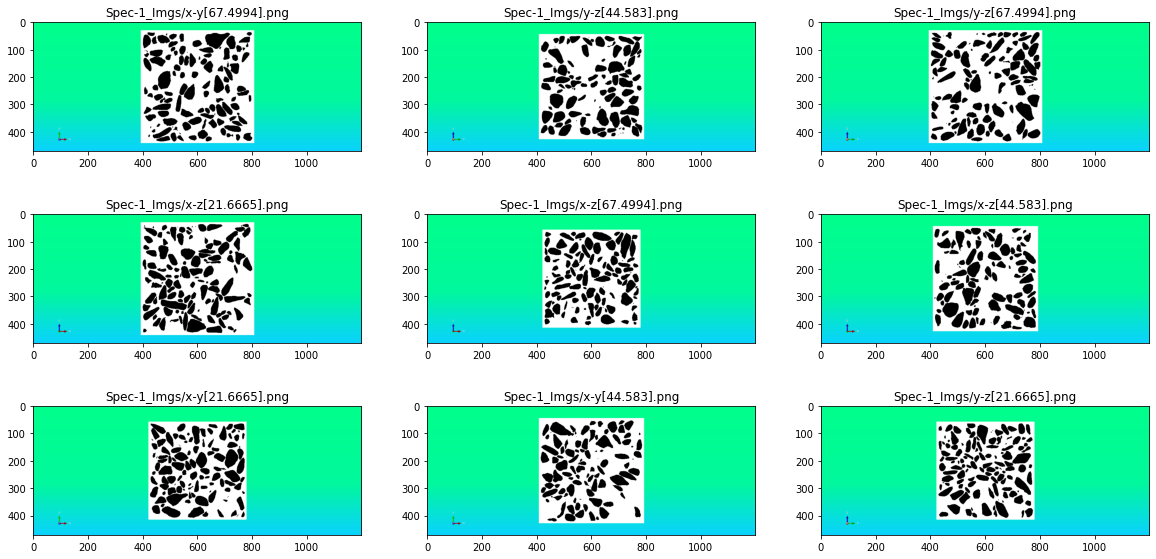

In [4]:
print(f"* The features \ images are contained in the columns {fabrics_df.columns[-1]}.")
print(f"\n* The cells of this column have type {type(fabrics_df.iloc[0, -1])}.")
print(f"\n* Each cell contains {len(fabrics_df.iloc[0, -1])} images.")
print(f"\n* The first image of the first cell is {fabrics_df.iloc[0, -1][0]}")
print("\n* Images of the first cell / rev:")
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
for index, image_path in enumerate(fabrics_df.iloc[0, -1]):
    current_row = index // 3
    current_col = index % 3
    image = plt.imread(image_path)
    axs[current_row, current_col].imshow(image)
    axs[current_row, current_col].set_title("/".join(image_path.split("/")[-2:]))
plt.show()


We see that there are large borders around the images. We will need to crop, as we don't want our model to spend time learning the green / blue background. Pytorch will help us to crop.

### Targets analysis

In [5]:
print(
    f"* The first columns is {fabrics_df.columns[0]}. We will need to remove this column as we don't want our network to learn from the rev's id."
)
print(f"\n* The targets are stored in {fabrics_df.columns[1:]}.")
print(f"\n* The targets have type \n{fabrics_df.iloc[:, 1:-1].dtypes}.")


* The first columns is id. We will need to remove this column as we don't want our network to learn from the rev's id.

* The targets are stored in Index(['orientation-0_mean', 'orientation-1_mean', 'orientation-2_mean',
       'orientation-3_mean', 'orientation-4_mean', 'orientation-5_mean',
       'orientation-0_std', 'orientation-1_std', 'orientation-2_std',
       'orientation-3_std', 'orientation-4_std', 'orientation-5_std',
       'aspectratio-0_mean', 'aspectratio-1_mean', 'aspectratio-0_std',
       'aspectratio-1_std', 'size_mean', 'size_std', 'solidity_mean',
       'solidity_std', 'roundness_mean', 'roundness_std', 'volume_fraction',
       'photos'],
      dtype='object').

* The targets have type 
orientation-0_mean    float64
orientation-1_mean    float64
orientation-2_mean    float64
orientation-3_mean    float64
orientation-4_mean    float64
orientation-5_mean    float64
orientation-0_std     float64
orientation-1_std     float64
orientation-2_std     float64
orientatio

We can check the correlation matrix between all the targets.

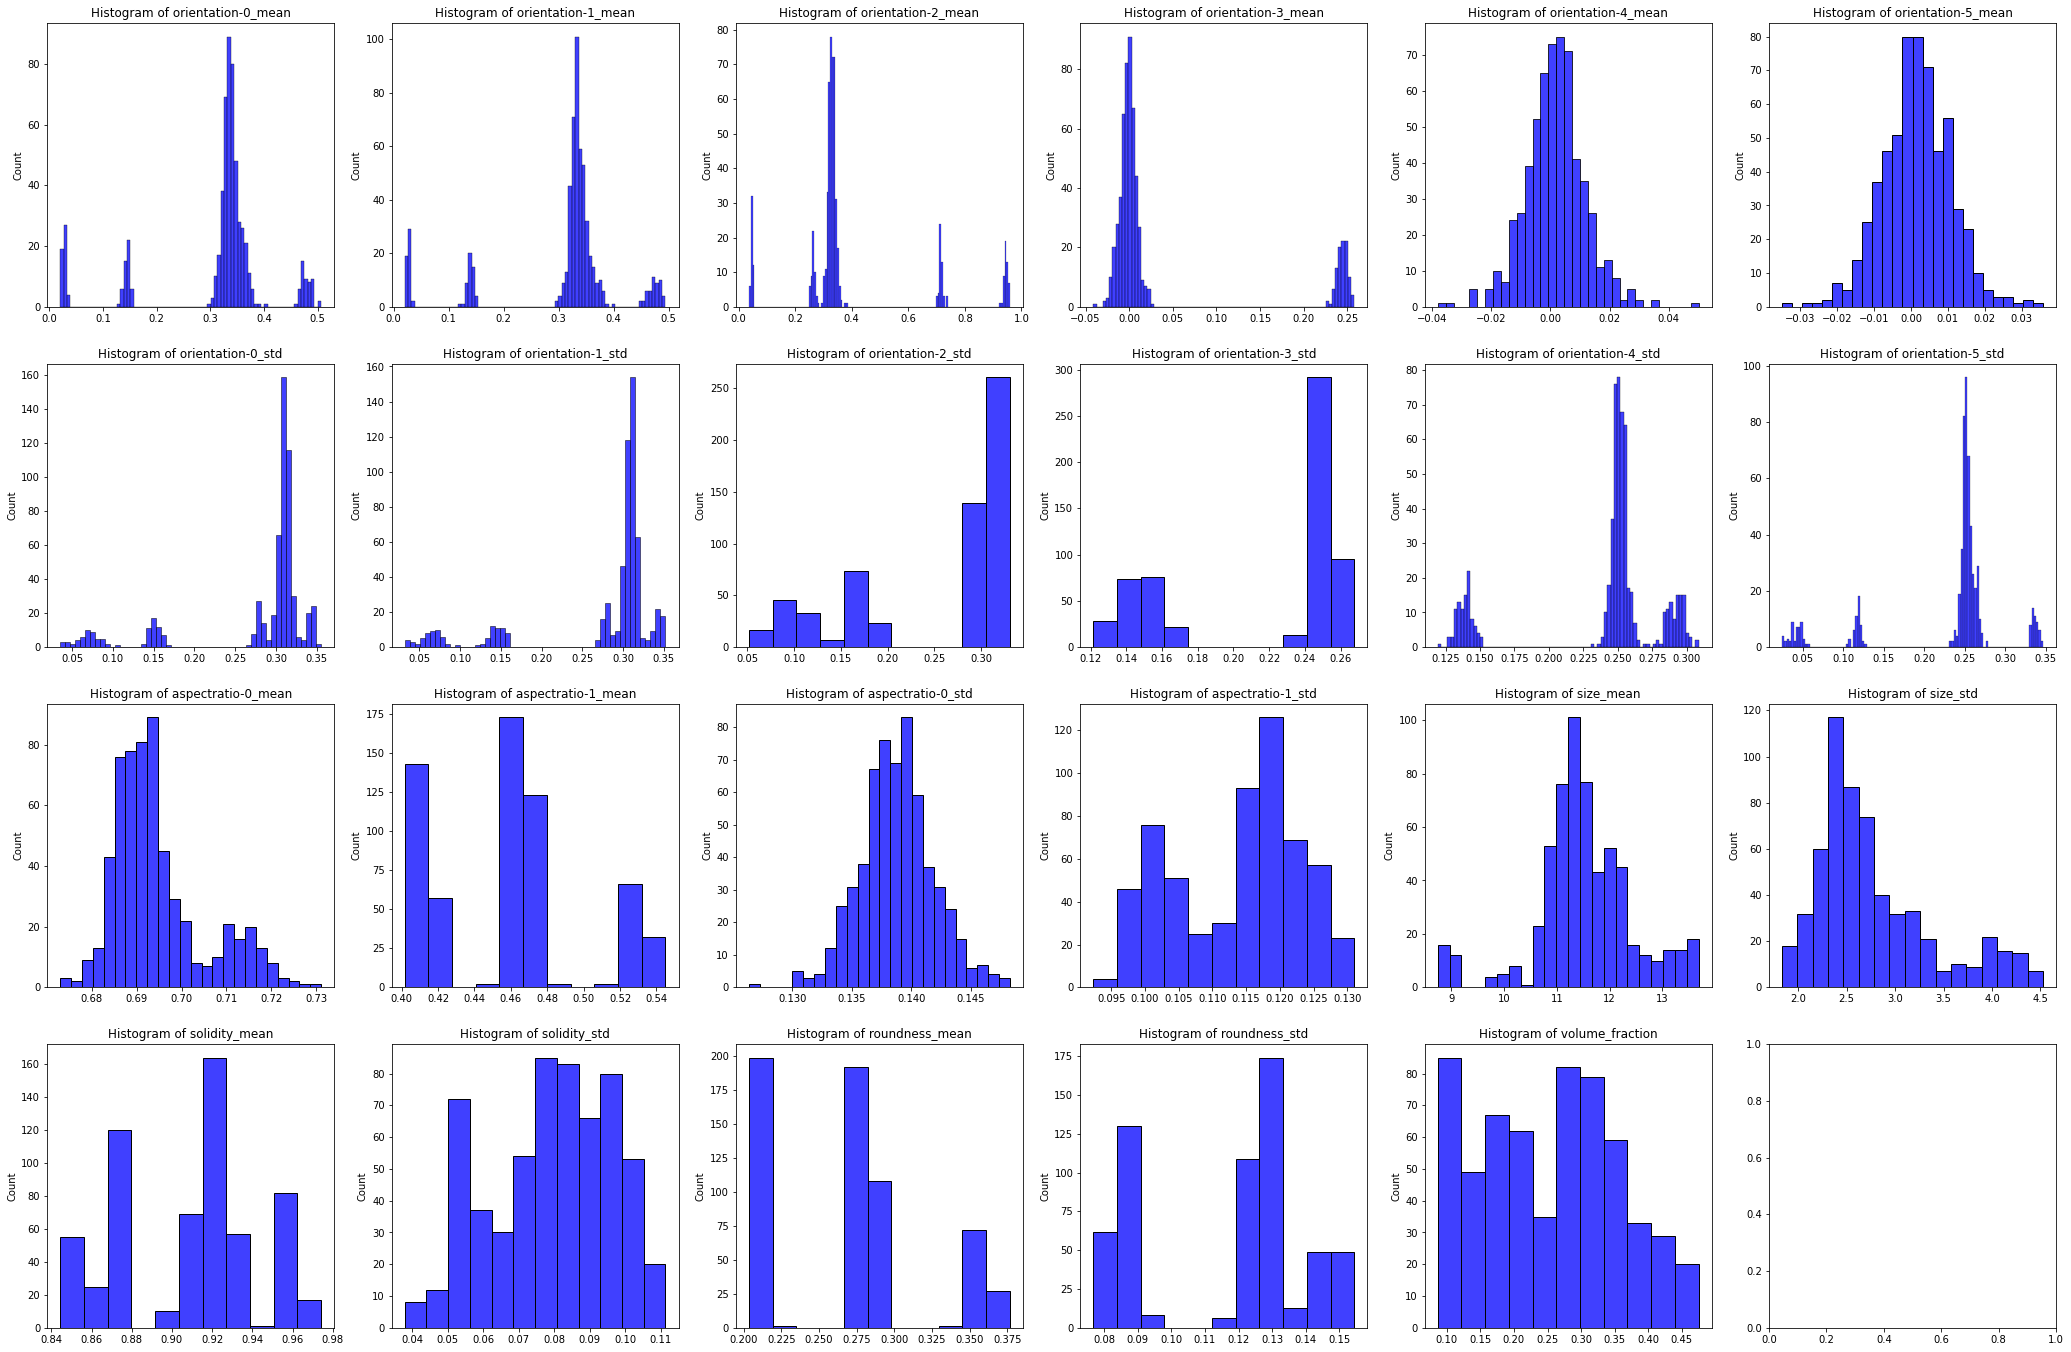

<Figure size 432x288 with 0 Axes>

In [6]:
fig, axs = plotting.plot_hist(fabrics_df.iloc[:, 1:-1], nb_hist_per_line=6)
plt.show()
plt.savefig("images/histogram_targets.png", transparent=False)

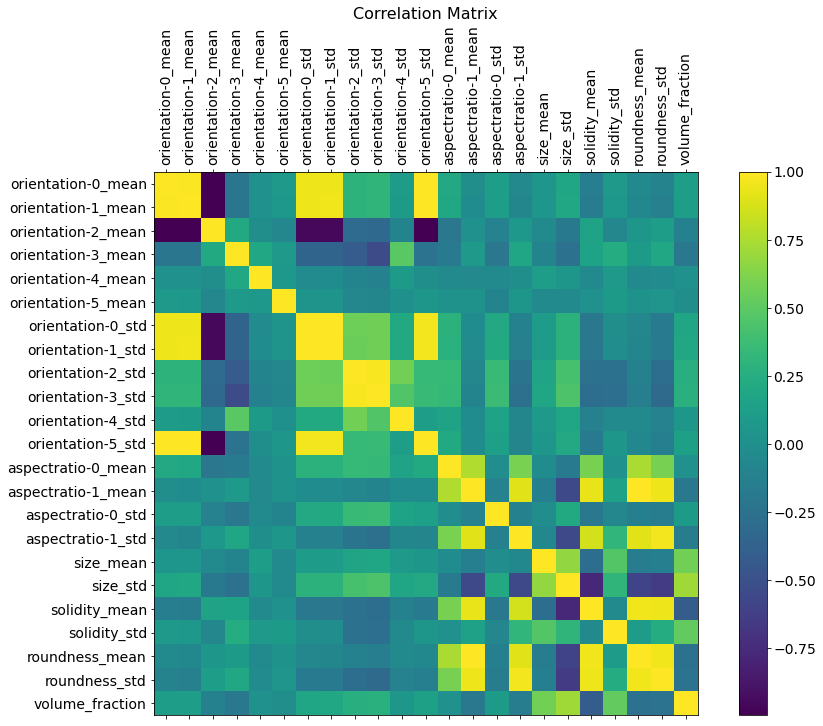

<Figure size 432x288 with 0 Axes>

In [7]:
fig, axs = plotting.plot_correlation(fabrics_df)
plt.show()
plt.savefig("images/correlation_matrix.png", transparent=False)

We notice that:

* some descriptors are related like the aspect ratios and the the roundness, it is physically explainable.
* some descriptors are related like the orientation vectors, and I don't understand why they are
* the mean of the descriptors are often related to their stds and I don't understand why.

## OPTIONAL: SAVING THE DATAFRAME IN WANDB.

Wandb is a platform where we can store objects like dataframes, model weights, model losses, ...
This is very useful to keep track of the version of the dataset, and to be sure to always use the latest version.

You can find the repository at https://wandb.ai/matiasetcheverry/microstructure-reconstruction.

### Save the fabric descriptors

In [11]:
import wandb
from utils import wandb_api

wandb_api.login()

run = wandb.init(
    project="microstructure-reconstruction",
    group="upload_artifact",
    job_type="upload_dataframe",
)

raw_data = wandb.Artifact(
    name="raw_fabrics",
    type="Fabrics",
    description="original 600 fabrics with paths to images",
)

table = wandb.Table(dataframe=fabrics_df)
raw_data.add(table, name="fabrics")
run.log_artifact(raw_data)
run.finish()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


### Restore the fabric descriptors

In [ ]:
run = wandb.init(
    project="microstructure-reconstruction",
    group="Naive Network",
    job_type="test",
)

data_at = run.use_artifact("raw_fabrics" + ":3_images")
data_dir = data_at.download()
fabrics_df = wandb_api.convert_table_to_dataframe(data_at.get("fabrics"))
